# Analysis of the local Sherwood number

The local Sherwood number is analyzed for various scenarios:

- mesh dependency for a $d_b=1.8~mm$ air bubble rising in water
- comparison of slip and Dirichlet boundary conditions at the bubble surface
- reactive local Sherwood number and enhancement factor for the bubble mentioned before and additionally for dimpled ellipsoidal, spherical cap and stable skirted bubbles

## Dependencies

This notebook has no dependencies to other notebooks or to the data set.

TODO: Add raw data to data set.

The OpenFOAM setups based on which the Sherwood numbers were computed can be found [here](https://github.com/AndreWeiner/phd_openfoam/tree/master/test_cases/speciesFoam).

## Mesh dependency

The mesh dependency study of the local Sherwood number shows that the global Sherwood number does not change necessarily monotonously with increasing mesh resolution.

In [1]:
import helper_module as hm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline

data_path = "../data/localSh/"
output_path = "../output/"

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")
    
def scale_01(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def smooth_and_sort(phi, array, sigma):
    phi_order = np.argsort(phi)
    phi_sorted = phi[phi_order]
    array_smooth_sorted = gaussian_filter1d(array[phi_order], sigma=sigma)
    return phi_sorted, array_smooth_sorted
    
names_phys = ["x", "y", "area", "gradA"]
names_decay = ["x", "y", "area", "gradA", "P"]
names_single = ["x", "y", "area", "gradA", "P", "B"]
names_cons = ["x", "y", "area", "gradA", "P", "B", "S"]
all_names = [names_phys, names_decay, names_single, names_cons]

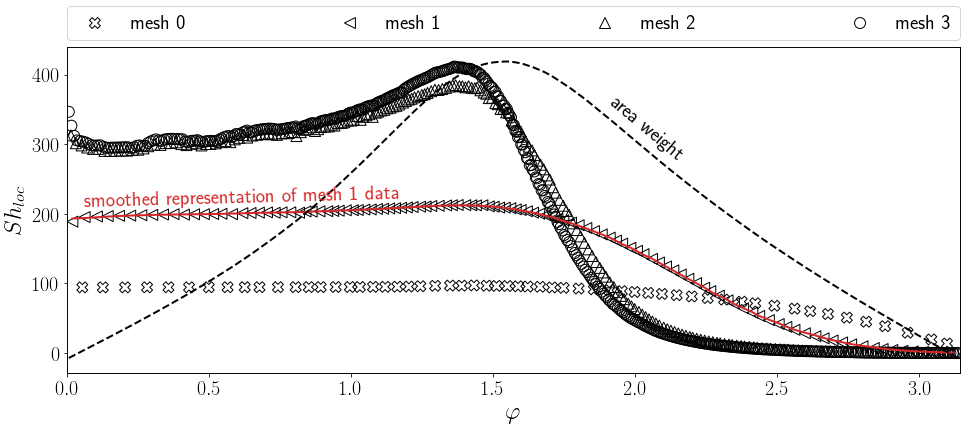

In [2]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
ax_area = ax.twinx()

wa_05_meshes = ["water_05_phys_m{:1d}.csv".format(i) for i in range(4)]
labels = ["mesh {:1d}".format(i) for i in range(4)]
markers = ["X", "<", "^", "o"]

for i, mesh in enumerate(wa_05_meshes):
    local_data = pd.read_csv(data_path + mesh, header=0, names=names_phys)
    rad, phi = hm.transform_polar_2D(local_data.x.values, local_data.y.values)
    ax.scatter(phi, local_data.gradA.values, marker=markers[i], facecolors='none', edgecolor="k", s=120, lw=1.0, label=labels[i])
    if i is 1:
        phi_sorted, gradA_s = smooth_and_sort(phi, local_data.gradA.values, 2.0)
        ax.plot(phi_sorted, gradA_s, color="C3", lw=2, ls="-")
        ax_area.text(0.06, 0.54, "smoothed representation of mesh 1 data", rotation=1.5, color="C3", fontsize=hm.fontsize_legend)
    if i is 3:
        phi_order = np.argsort(phi)
        phi_sorted = phi[phi_order]
        x_sorted = local_data.x.values[phi_order]
        area_weight = scale_01(x_sorted)
        ax_area.plot(phi_sorted, area_weight, lw=2.0, ls="--", color="k")
        ax_area.text(1.9, 0.85, "area weight", rotation=-40, fontsize=hm.fontsize_legend)

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)
ax_area.set_yticks([])
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("water_05_phys_local_sh_meshdep")

## Influence of the velocity boundary condition at the bubble surface

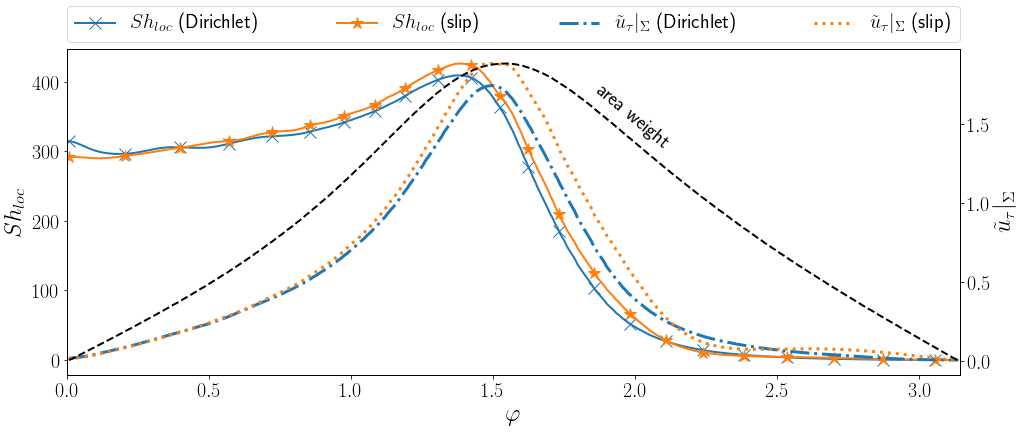

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
ax_vel = ax.twinx()
ax_area = ax.twinx()

sh = pd.read_csv("../data/localSh/water_05_phys_m3.csv", header=0, names=names_phys)
sh_slip = pd.read_csv("../data/localSh/water_05_phys_slip_m3.csv", header=0, names=names_phys)

names_vel = ["x", "y", "Af", "U_tau", "pf", "dtau_Utau"]
vel = pd.read_csv("../data/localVel/water_05_m3.csv", names=names_vel, header=0)
vel_slip = pd.read_csv("../data/localVel/water_05_slip_m3.csv", names=names_vel, header=0)

rad, phi = hm.transform_polar_2D(vel.x.values, vel.y.values)

labels = ["$Sh_{loc}$ (Dirichlet)", "$Sh_{loc}$ (slip)"]
marker = ["x", "*"]
colors = ["C0", "C1"]
lines = []
for i, data in enumerate([sh, sh_slip]):
    phi_sort, grad_s = smooth_and_sort(phi, data.gradA, 5.0)
    lines.append(ax.plot(phi_sort, grad_s, lw=2, label=labels[i],
                         marker=marker[i], markevery=20, ms=12, color=colors[i])[0])

labels = [r"$\tilde{u}_\tau |_\Sigma$ (Dirichlet)", r"$\tilde{u}_\tau |_\Sigma$ (slip)"]
styles = ["-.", ":"]
for i, data in enumerate([vel, vel_slip]):
    phi_sort, U_tau = smooth_and_sort(phi, data.U_tau.values / 2.76750992, 5.0)
    lines.append(ax_vel.plot(phi_sort, U_tau, lw=3.0, ls=styles[i], label=labels[i], color=colors[i])[0])
    
phi_sort, x_sort = smooth_and_sort(phi, sh.x.values, 1.0)
ax_area.plot(phi_sort, x_sort, color="k", ls="--", lw=2)
ax_area.text(1.85, 0.56, "area weight", rotation=-40, fontsize=hm.fontsize_legend)
ax_area.set_yticks([])

    
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)
ax_vel.tick_params(labelsize=hm.fontsize_tick)
ax_vel.set_ylabel(r"$\tilde{u}_\tau |_\Sigma$", fontsize=hm.fontsize_label)
ax.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("water_05_dir_vs_slip")

## Local Sherwood number and enhancement for various bubbles

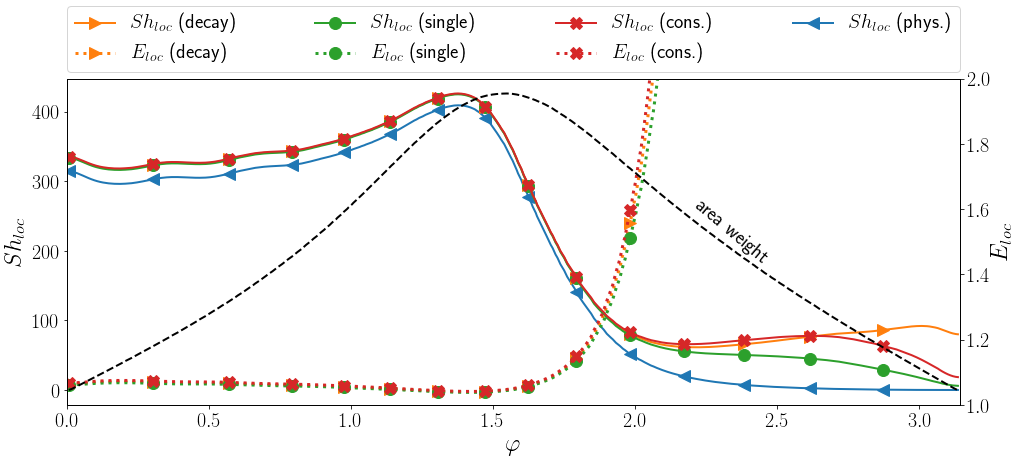

In [4]:
types = ["phys", "decay", "single", "cons"]
wa_05_files = [data_path + "water_05_{:s}_m3.csv".format(name) for name in types]

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
ax_en = ax.twinx()
ax_area = ax.twinx()

makers = ["<", ">", "o", "X"]
colors = ["C{:1d}".format(i) for i in range(4)]
labels = ["(phys.)", "(decay)", "(single)", "(cons.)"]
lines = []
data_ref = pd.read_csv(wa_05_files[0], header=0, names=all_names[0])
rad, phi = hm.transform_polar_2D(data_ref.x.values, data_ref.y.values)
phi_ref, grad_ref = smooth_and_sort(phi, data_ref.gradA.values, 5.0)
phi_sort, x_sort = smooth_and_sort(phi, data_ref.x.values, 1.0)
ax_area.plot(phi_sort, x_sort, color="k", ls="--", lw=2)
ax_area.text(2.2, 0.38, "area weight", rotation=-40, fontsize=hm.fontsize_legend)
ax_area.set_yticks([])

for i, file in enumerate(wa_05_files):
    data = pd.read_csv(file, header=0, names=all_names[i])
    rad, phi = hm.transform_polar_2D(data.x.values, data.y.values)
    phi_s, grad_s = smooth_and_sort(phi, data.gradA.values, 5.0)
    lines.append(ax.plot(phi_s, grad_s, lw=2, marker=makers[i], markevery=30, ms=12, color=colors[i],
                         label=r"$Sh_{loc}$" + " {:s}".format(labels[i]))[0])
    if i > 0:
        Eloc = grad_s / grad_ref
        lines.append(ax_en.plot(phi_ref, Eloc, lw=3, ls=":", marker=makers[i], markevery=30, ms=12, color=colors[i],
                             label=r"$E_{loc}$" + " {:s}".format(labels[i]))[0])

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)

ax_en.set_ylabel(r"$E_{loc}$", fontsize=hm.fontsize_label)
ax_en.tick_params(labelsize=hm.fontsize_tick)
ax_en.set_ylim(1, 2)

lines_sorted = lines[1:]
lines_sorted.append(lines[0])
ax.legend(handles=lines_sorted, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("water_05_local_sh")

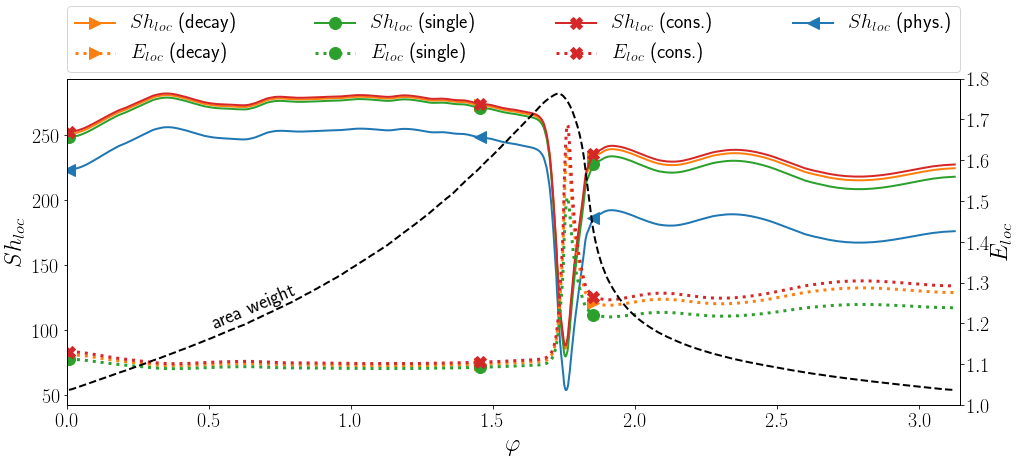

In [5]:
ba_03_files = [data_path + "bhaga_03_{:s}_m3.csv".format(name) for name in types]

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
ax_en = ax.twinx()
ax_area = ax.twinx()
lines = []
data_ref = pd.read_csv(ba_03_files[0], header=0, names=all_names[0])
rad, phi = hm.transform_polar_2D(data_ref.x.values, data_ref.y.values)
phi_ref, grad_ref = smooth_and_sort(phi, data_ref.gradA.values, 5.0)
phi_sort, x_sort = smooth_and_sort(phi, data_ref.x.values, 1.0)
ax_area.plot(phi_sort, x_sort, color="k", ls="--", lw=2)
ax_area.text(0.5, 0.27, "area weight", rotation=23, fontsize=hm.fontsize_legend)
ax_area.set_yticks([])

for i, file in enumerate(ba_03_files):
    data = pd.read_csv(file, header=0, names=all_names[i])
    rad, phi = hm.transform_polar_2D(data.x.values, data.y.values)
    phi_s, grad_s = smooth_and_sort(phi, data.gradA.values, 5.0)
    lines.append(ax.plot(phi_s, grad_s, lw=2, marker=makers[i], markevery=200, ms=12, color=colors[i],
                         label=r"$Sh_{loc}$" + " {:s}".format(labels[i]))[0])
    if i > 0:
        Eloc = grad_s / grad_ref
        lines.append(ax_en.plot(phi_ref, Eloc, lw=3, ls=":", marker=makers[i], markevery=200, ms=12, color=colors[i],
                             label=r"$E_{loc}$" + " {:s}".format(labels[i]))[0])

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)

ax_en.set_ylabel(r"$E_{loc}$", fontsize=hm.fontsize_label)
ax_en.tick_params(labelsize=hm.fontsize_tick)
ax_en.set_ylim(1, 1.8)

lines_sorted = lines[1:]
lines_sorted.append(lines[0])
ax.legend(handles=lines_sorted, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("bhaga_03_local_sh")

In [6]:
import torch

def split_inner_outer(name, phi, rad, gradA):
    phi_tensor = torch.from_numpy(phi.astype(np.float64)).unsqueeze(-1)
    model_path = "../output/models/" + name + "_inout_ts.pt"
    model = torch.jit.load(model_path)
    rad_inout = model.forward(phi_tensor).detach().numpy()
    inner_dist = np.absolute(rad - rad_inout[:, 0])
    outer_dist = np.absolute(rad - rad_inout[:, 1])
    inner_cont = inner_dist < outer_dist
    outer_cont = outer_dist < inner_dist
    return phi[inner_cont], rad[inner_cont], gradA[inner_cont], phi[outer_cont], rad[outer_cont], gradA[outer_cont]

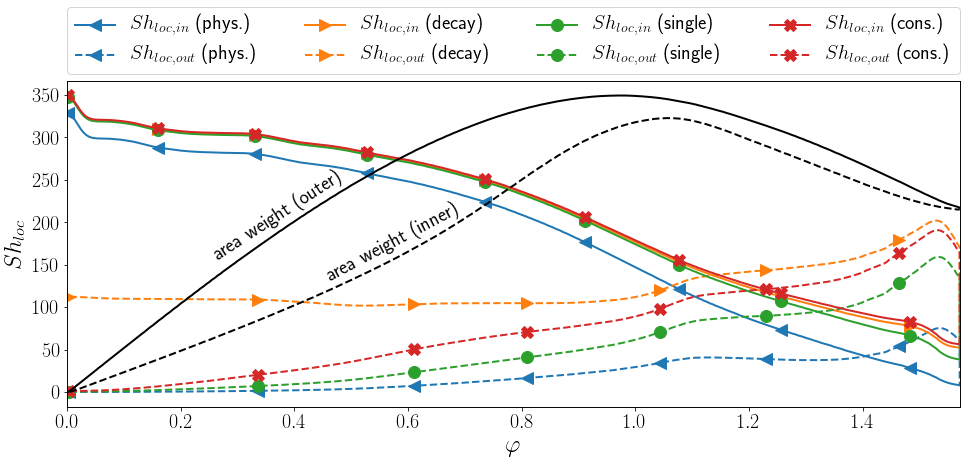

In [7]:
ba_02_files = [data_path + "bhaga_02_{:s}_m3.csv".format(name) for name in types]

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
#ax_en = ax.twinx()
ax_area = ax.twinx()
lines = []

for i, file in enumerate(ba_02_files):
    data = pd.read_csv(file, header=0, names=all_names[i])
    rad, phi = hm.transform_polar_2D(data.x.values, data.y.values + abs(np.min(data.y.values)))
    phi_in, rad_in, grad_in, phi_out, rad_out, grad_out = split_inner_outer("bhaga_02_l16", phi, rad, data.gradA.values)
    phi_1, grad_1 = smooth_and_sort(phi_out, grad_out, 5.0)
    lines.append(ax.plot(phi_1, grad_1, lw=2, marker=makers[i], markevery=50, ms=12, color=colors[i],
                         label=r"$Sh_{loc,in}$" + " {:s}".format(labels[i]))[0])
    phi_2, grad_2 = smooth_and_sort(phi_in, grad_in, 5.0)
    phi_2 = np.append(phi_2, np.asarray(phi_1[-1]))
    grad_2 = np.append(grad_2, np.asarray(grad_1[-1]))
    lines.append(ax.plot(phi_2, grad_2, lw=2, marker=makers[i], markevery=50, ms=12, color=colors[i], ls="--",
                         label=r"$Sh_{loc,out}$" + " {:s}".format(labels[i]))[0])
    if i is 0:
        # phi_ref_in = phi_2
        # phi_ref_out = phi_1
        # grad_ref_in = grad_2
        # grad_ref_out = grad_1

        phi_in, _, x_in, phi_out, _, x_out = split_inner_outer("bhaga_02_l16", phi, rad, data.x.values)
        phi_, x_ = smooth_and_sort(phi_out, x_out, 1.0)
        ax_area.plot(phi_, x_, lw=2, color="k", ls="-")
        ax_area.text(0.25, 0.46, "area weight (outer)", rotation=33, fontsize=hm.fontsize_legend)
        phi_, x_ = smooth_and_sort(phi_in, x_in, 1.0)
        ax_area.plot(phi_, x_, lw=2, color="k", ls="--")
        ax_area.text(0.45, 0.39, "area weight (inner)", rotation=28, fontsize=hm.fontsize_legend)
        
    if i > 0:
        pass
        #Eloc_in = grad_2 / grad_ref_in
        #Eloc_out = grad_1 / grad_ref_out
        #lines.append(ax_en.plot(phi_ref_in, Eloc_in, lw=3, ls=":", marker=makers[i], markevery=200, ms=12, color=colors[i],
        #                     label=r"$E_{loc}$" + " {:s}".format(labels[i]))[0])
        #lines.append(ax_en.plot(phi_ref_out, Eloc_out, lw=3, ls=":", marker=makers[i], markevery=200, ms=12, color=colors[i],
        #                     label=r"$E_{loc}$" + " {:s}".format(labels[i]))[0])
    
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, 0.5*np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)

#ax_en.set_ylabel(r"$E_{loc}$", fontsize=hm.fontsize_label)
#ax_en.tick_params(labelsize=hm.fontsize_tick)
#ax_en.set_ylim(1, 100)

ax_area.set_yticks([])

ax.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("bhaga_02_local_sh")

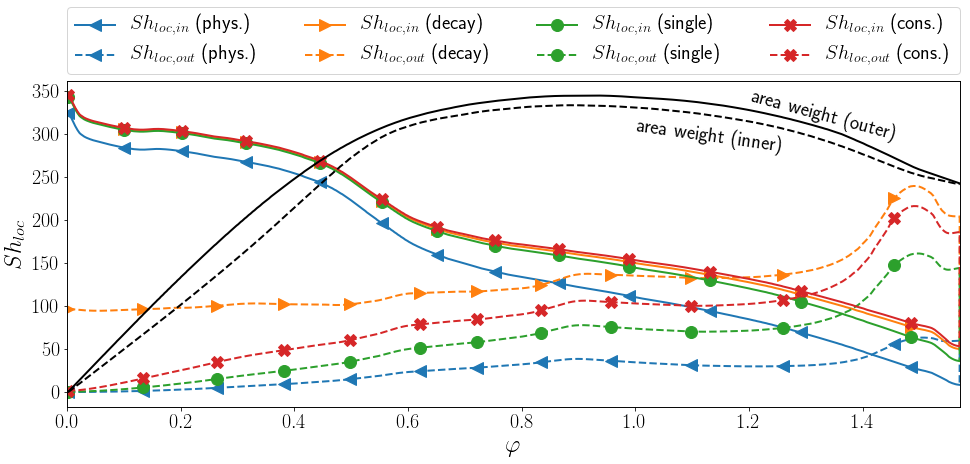

In [8]:
ba_04_files = [data_path + "bhaga_04_{:s}_m3.csv".format(name) for name in types]

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
ax_area = ax.twinx()
lines = []

for i, file in enumerate(ba_04_files):
    data = pd.read_csv(file, header=0, names=all_names[i])
    rad, phi = hm.transform_polar_2D(data.x.values, data.y.values + abs(np.min(data.y.values)))
    phi_in, rad_in, grad_in, phi_out, rad_out, grad_out = split_inner_outer("bhaga_04_l16", phi, rad, data.gradA.values)
    phi_1, grad_1 = smooth_and_sort(phi_out, grad_out, 5.0)
    lines.append(ax.plot(phi_1, grad_1, lw=2, marker=makers[i], markevery=50, ms=12, color=colors[i],
                         label=r"$Sh_{loc,in}$" + " {:s}".format(labels[i]))[0])
    phi_2, grad_2 = smooth_and_sort(phi_in, grad_in, 5.0)
    phi_2 = np.append(phi_2, np.asarray(phi_1[-1]))
    grad_2 = np.append(grad_2, np.asarray(grad_1[-1]))
    lines.append(ax.plot(phi_2, grad_2, lw=2, marker=makers[i], markevery=50, ms=12, color=colors[i], ls="--",
                         label=r"$Sh_{loc,out}$" + " {:s}".format(labels[i]))[0])
    if i is 0:
        phi_in, _, x_in, phi_out, _, x_out = split_inner_outer("bhaga_04_l16", phi, rad, data.x.values)
        phi_, x_ = smooth_and_sort(phi_out, x_out, 1.0)
        ax_area.plot(phi_, x_, lw=2, color="k", ls="-")
        ax_area.text(1.2, 0.78, "area weight (outer)", rotation=-15, fontsize=hm.fontsize_legend)
        phi_, x_ = smooth_and_sort(phi_in, x_in, 1.0)
        ax_area.plot(phi_, x_, lw=2, color="k", ls="--")
        ax_area.text(1.0, 0.70, "area weight (inner)", rotation=-8, fontsize=hm.fontsize_legend)
    
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$Sh_{loc}$", fontsize=hm.fontsize_label)
ax.set_xlim(0, 0.5*np.pi)
ax.tick_params(labelsize=hm.fontsize_tick)

ax_area.set_yticks([])

ax.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
          ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("bhaga_04_local_sh")